In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
sn.set(rc={'figure.figsize':(9,3)})

%matplotlib inline

## Envíos

In [91]:
envíos = pd.read_csv('envios.txt', sep='|', parse_dates=['fecha'], index_col='fecha')
envíos.head()

# la cantidad de envíos no parece ser relevante
envíos.drop(columns='cantidad_envios', inplace=True)

# parece conveniente comenzar desde inicios del 2012 para capturar mejor la periocidad anual
índice = pd.date_range(start='2012-01-01', end='2014-11-30', freq='D')
índice.name = 'fecha'

series = []

for id_pos, grupo in envíos.groupby('id_pos'):
    aux = grupo.groupby(level='fecha').unidades_despachadas.sum()
    aux.name = id_pos
    series.append(aux.reindex(índice))

envíos = pd.concat(series, axis=1).fillna(0)

## Ventas

In [99]:
ventas = pd.read_csv('ventas.txt', sep='|', parse_dates=['fecha'], index_col=['fecha'])
ventas.tail()

,id_pos,unidades,canal
fecha,,,
2014-11-30,30716,1,ALMACEN
2014-11-30,7911,1,ALMACEN
2014-11-30,9751,1,ALMACEN
2014-11-30,16534,2,ALMACEN
2014-11-30,16553,2,ALMACEN


In [100]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266436 entries, 2012-10-01 to 2014-11-30
Data columns (total 3 columns):
id_pos      266436 non-null int64
unidades    266436 non-null int64
canal       266436 non-null object
dtypes: int64(2), object(1)
memory usage: 8.1+ MB


Detecté puntos de venta duplicados con **distintos canales**. Solo se especifica `id_pos` en las predicciones a entregar. El problema se podría solucionar tirando la variable. 

In [101]:
ventas.drop(columns='canal', inplace=True)

También detecté para un `id_pos` duplicados para una misma fecha. La solución es sumar las `unidades` de los registros.

In [102]:
# parece conveniente comenzar desde inicios del 2012 para capturar mejor la periocidad anual
índice = pd.date_range(start='2012-01-01', end='2014-11-30', freq='D')

series = []

for id_pos, grupo in ventas.groupby('id_pos'):
    aux = grupo.groupby(level='fecha').unidades.sum()
    aux.name = id_pos
    series.append(aux.reindex(índice))

ventas = pd.concat(series, axis=1).fillna(0)

## Puntos de venta

In [204]:
pos = pd.read_csv('pos.csv')
pos_válidos = pd.read_csv('ejemploRespuesta.csv', header=None, names=['id_pos','unidades'], usecols=['id_pos'])

import numpy as np
pos.id_pos = pd.to_numeric(pos.id_pos, errors='coerce')
pos.dropna(subset=['id_pos'], inplace=True)
pos.id_pos = pos.id_pos.astype(int)

posta = pd.merge(pos, pos_válidos, on='id_pos', how='right').set_index('id_pos')

Filtro las columnas de `envíos` y `ventas` para dejar solamente POS válidos.

In [193]:
envíos = envíos.loc[:, posta.index].fillna(0)
ventas = ventas.loc[:, posta.index].fillna(0)

## Stock

In [116]:
# hay que agrupar por año porque los panes dulces se echan a perder
stock = (envíos - ventas).groupby(lambda x: x.year).cumsum()

In [119]:
# ¿algún día algún POS quedó con stock negativo?
stock.loc[:,stock.lt(0).any()].tail()

,3143,3164,3177,3179,3182,3210,3216,3247,3260,3279,...,32199,34348,34523,34684,34925,36372,40354,40361,42270,58817
fecha,,,,,,,,,,,,,,,,,,,,,
2014-11-26,24.0,128.0,35.0,83.0,60.0,78.0,12.0,45.0,70.0,43.0,...,47.0,36.0,23.0,24.0,23.0,24.0,24.0,11.0,24.0,24.0
2014-11-27,24.0,128.0,35.0,83.0,60.0,77.0,12.0,45.0,70.0,43.0,...,47.0,36.0,23.0,24.0,23.0,24.0,24.0,11.0,24.0,24.0
2014-11-28,24.0,125.0,35.0,82.0,60.0,77.0,12.0,45.0,70.0,41.0,...,45.0,36.0,23.0,24.0,22.0,24.0,24.0,11.0,24.0,24.0
2014-11-29,24.0,125.0,34.0,82.0,60.0,77.0,12.0,45.0,69.0,40.0,...,44.0,36.0,23.0,24.0,22.0,24.0,24.0,11.0,24.0,24.0
2014-11-30,24.0,125.0,34.0,82.0,60.0,74.0,12.0,45.0,67.0,40.0,...,44.0,36.0,23.0,24.0,22.0,24.0,24.0,11.0,24.0,24.0


Polémico lo del stock negativo pero al fin y al cabo estoy haciendo esto para detectar POS activos. Si le enviaron y/o vendió entonces estuvo activo.

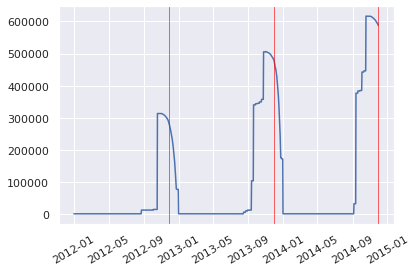

In [135]:
stock_agregado = stock.sum(axis=1)

import datetime as dt

sn.lineplot(data=stock_agregado)
plt.axvline(x=dt.datetime(2012,11,30), color='red', linewidth=0.6)
plt.axvline(x=dt.datetime(2013,11,30), color='red', linewidth=0.6)
plt.axvline(x=dt.datetime(2014,11,30), color='red', linewidth=0.6)
plt.xticks(rotation=30);

Parece que el stock podría servir para tener una idea de los POS activos durante la temporada sin requerir los datos de diciembre.

In [181]:
pos_activos = stock[stock.index.month != 12].ne(0).groupby(lambda x: x.year).any()

conteo_pos_activos = pos_activos.sum(axis=1) 
conteo_pos_activos

2012     7648
2013    11479
2014    12368
dtype: int64

Convertimos en atributo si el POS estuvo activo en el año en cuestión.

In [208]:
posta = posta.join(pos_activos.T.rename(columns=lambda x: 'activo_' + str(x)))

Quitamos de encima la estacionalidad semanal.

In [143]:
ventas_semanales = ventas.resample('W', level=0).sum()
agregado = ventas_semanales.sum(axis=1)
#temporada = agregado[agregado.index.month.isin([9,10,11,12])]

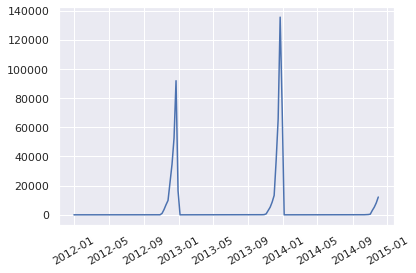

In [145]:
sn.lineplot(data=agregado);
plt.xticks(rotation=30);

In [159]:
normalizado = agregado.copy()

for año in range(2012,2015):
    normalizado[str(año)] /= conteo_pos_activos[año]

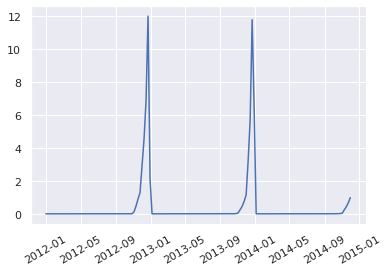

In [161]:
sn.lineplot(data=normalizado);
plt.xticks(rotation=30);

### Pareto

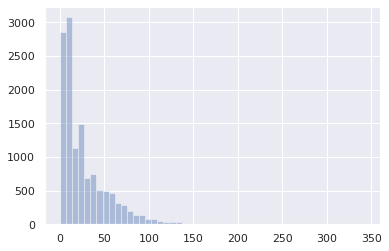

In [209]:
sn.distplot(a=ventas['2013'].sum(), kde=False, hist=True, bins=50);

### Predictores

In [240]:
data = posta.assign(ventas_2013=ventas['2013'].sum()).query('activo_2013 == True').dropna()
X = data.drop(columns=['activo_2012', 'activo_2013', 'activo_2014', 'ventas_2013'])
y = data['ventas_2013']

In [267]:
X.corr().style.background_gradient(cmap='viridis', low=-.5, high=.5)

,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,pct_10a14,pct_15a19,pct_20a24,pct_25a29,pct_30a34,pct_35a39,pct_40a44,pct_45a49,pct_50a54,pct_55a59,pct_60a64,pct_65a69,pct_70a74,pct_75a79,pct_80a84,pct_85ainf,pct_bachelors,pct_doctorados,pct_secundario,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar
competidores,1,0.0716827,0.0876397,0.191394,-0.0106977,-0.0792518,-0.103502,-0.0401949,0.0343358,0.158013,0.137933,0.085795,0.0197969,-0.0293042,-0.0681156,-0.074145,-0.0699896,-0.0695998,-0.0621854,-0.0399116,-0.00820309,0.0166312,0.152135,0.103296,-0.157858,0.136568,0.0547852,0.0884162,0.12169,0.155685,0.107602,0.112439
ingreso_mediana,0.0716827,1,0.978546,0.13795,-0.159207,0.0272483,0.149383,-0.0977824,-0.264474,-0.0822905,0.0267713,0.261765,0.440798,0.477304,0.344488,0.182736,0.0698574,0.00570178,-0.0886312,-0.142574,-0.11442,-0.059237,0.711073,0.400768,-0.548744,0.71412,-0.0353797,-0.013854,0.156057,0.114676,-0.0437331,0.710035
ingreso_promedio,0.0876397,0.978546,1,0.195244,-0.206176,-0.0461938,0.0668238,-0.109878,-0.238694,-0.0410975,0.0416887,0.244028,0.405418,0.442814,0.319542,0.184359,0.0854221,0.0244202,-0.0695763,-0.116077,-0.0783853,-0.0192897,0.771667,0.478082,-0.624273,0.779956,0.0186904,0.0386886,0.198274,0.163406,0.0207584,0.771316
densidad_poblacional,0.191394,0.13795,0.195244,1,-0.00614697,-0.197637,-0.263056,-0.0948552,0.0573279,0.404571,0.402409,0.29793,0.0962618,-0.0304177,-0.151819,-0.171503,-0.159306,-0.166652,-0.16043,-0.137203,-0.114537,-0.0702409,0.272824,0.216253,-0.317486,0.291876,0.201598,0.501124,0.85426,0.610603,0.444863,0.476278
pct_0a5,-0.0106977,-0.159207,-0.206176,-0.00614697,1,0.790439,0.531476,-0.0165265,-0.0439755,0.197312,0.331892,0.336063,0.0858949,-0.164301,-0.313781,-0.441862,-0.511281,-0.517375,-0.475824,-0.444148,-0.400555,-0.321725,-0.284774,-0.292465,0.0918544,-0.311943,-0.149638,0.0138299,-0.0222984,-0.0406043,-0.193251,-0.219159
pct_5a9,-0.0792518,0.0272483,-0.0461938,-0.197637,0.790439,1,0.856502,0.0432538,-0.258416,-0.204922,0.00249865,0.250364,0.264687,0.113025,-0.0296161,-0.207266,-0.32006,-0.344325,-0.341624,-0.34546,-0.346349,-0.307321,-0.286511,-0.339383,0.157047,-0.314673,-0.288882,-0.169372,-0.170716,-0.182097,-0.396414,-0.205824
pct_10a14,-0.103502,0.149383,0.0668238,-0.263056,0.531476,0.856502,1,0.0742534,-0.384643,-0.441768,-0.227645,0.132008,0.349762,0.334678,0.229337,0.0295824,-0.116674,-0.167926,-0.19163,-0.226228,-0.268292,-0.255659,-0.253026,-0.348398,0.20133,-0.276343,-0.354438,-0.24488,-0.209399,-0.235178,-0.483712,-0.177793
pct_15a19,-0.0401949,-0.0977824,-0.109878,-0.0948552,-0.0165265,0.0432538,0.0742534,1,0.636473,-0.119941,-0.260118,-0.308977,-0.289149,-0.279476,-0.341699,-0.393728,-0.419866,-0.385417,-0.35093,-0.333286,-0.302179,-0.238864,-0.0934184,0.123491,-0.000481774,-0.0334521,0.0999057,-0.0288444,-0.122333,-0.0960858,0.250888,-0.149
pct_20a24,0.0343358,-0.264474,-0.238694,0.0573279,-0.0439755,-0.258416,-0.384643,0.636473,1,0.368108,0.0789787,-0.225725,-0.466773,-0.579014,-0.634601,-0.608445,-0.549881,-0.482767,-0.420667,-0.372586,-0.310309,-0.216718,0.0213273,0.289494,-0.145884,0.0655507,0.324044,0.136001,-0.0157949,0.0316189,0.494259,-0.110646
pct_25a29,0.158013,-0.0822905,-0.0410975,0.404571,0.197312,-0.204922,-0.441768,-0.119941,0.368108,1,0.845809,0.467725,0.000104327,-0.304537,-0.476836,-0.522161,-0.533233,-0.543335,-0.523671,-0.482037,-0.398775,-0.27985,0.246431,0.206953,-0.333469,0.197358,0.31116,0.373689,0.279591,0.298631,0.45954,0.118926


In [292]:
from sklearn.cluster import FeatureAgglomeration 
agglo = FeatureAgglomeration(n_clusters=3).fit(X) 

Xa = agglo.transform(X)

pd.DataFrame(Xa).corr().style.background_gradient(cmap='viridis', low=-.5, high=.5)

,0,1,2
0,1,0.476499,0.171275
1,0.476499,1,0.748323
2,0.171275,0.748323,1


In [238]:
from sklearn.ensemble import GradientBoostingRegressor

e = GradientBoostingRegressor(n_estimators=1000, max_depth=5, learning_rate=0.5, loss='lad').fit(X, y)

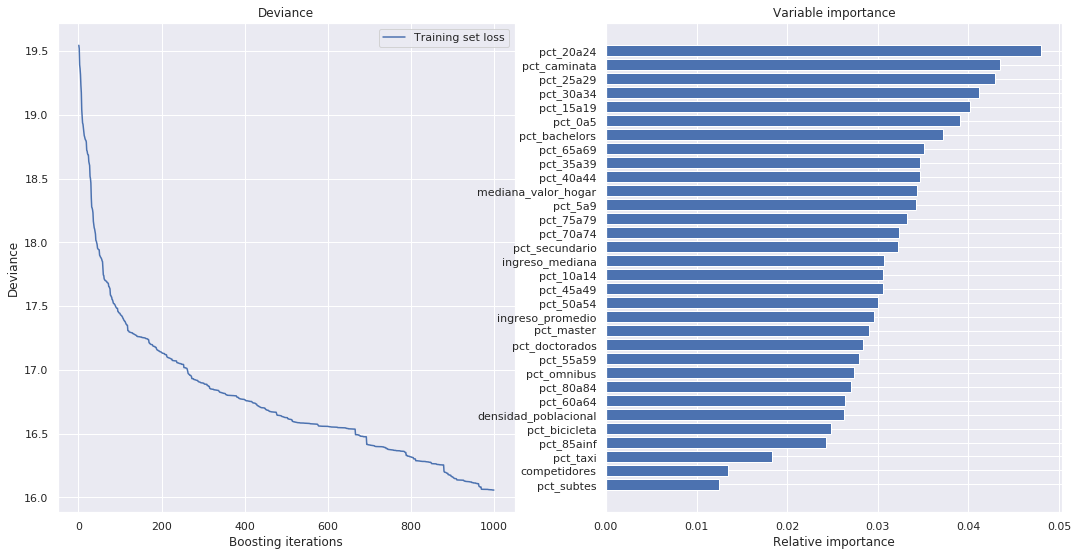

In [261]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(e.n_estimators_) + 1, e.train_score_, 'b-', label='Training set loss')
plt.legend(loc='upper right')
plt.xlabel('Boosting iterations')
plt.ylabel('Deviance')

sorted_idx = np.argsort(e.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, e.feature_importances_[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative importance')
plt.title('Variable importance');

In [224]:
posta[posta.activo_2013]

,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,pct_10a14,pct_15a19,pct_20a24,pct_25a29,...,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar,activo_2012,activo_2013,activo_2014
id_pos,,,,,,,,,,,,,,,,,,,,,
3142,12.0,50395.31667,68263.48667,17239.673330,6.796667,6.110000,5.020000,5.390000,7.696667,7.916667,...,7.396667,0.260000,6.733333,0.720000,0.210000,3.793333,252050.3467,True,True,True
3143,33.0,55256.52333,70989.74667,67764.126670,6.316667,5.903333,6.090000,5.933333,6.386667,6.670000,...,7.560000,0.366667,8.410000,22.810000,0.240000,3.006667,391646.2067,False,True,True
3144,38.0,43437.32000,58236.36500,8799.223333,7.270000,7.240000,7.055000,6.766667,7.895000,7.750000,...,6.546667,0.183333,1.466667,0.000000,0.025000,1.518333,137570.5233,True,True,True
3146,5.0,24541.12000,38500.06000,9049.910000,5.310000,4.650000,4.010000,12.920000,20.000000,7.940000,...,3.880000,0.420000,0.410000,0.000000,0.000000,7.590000,112830.8300,True,True,True
3147,21.0,47007.34750,63568.48250,7390.012500,5.985000,6.585000,6.672500,6.762500,6.230000,5.825000,...,5.087500,0.457500,0.397500,0.000000,0.155000,1.075000,128504.5700,True,True,True
3148,17.0,45155.59200,59637.55000,9499.356000,5.604000,5.498000,5.558000,6.640000,9.846000,7.520000,...,7.750000,1.642000,2.162000,0.054000,0.000000,3.612000,165903.9120,True,True,True
3150,6.0,57474.74500,77014.49500,13350.580000,5.685000,5.010000,4.750000,8.720000,10.850000,8.315000,...,11.910000,0.230000,6.325000,0.120000,0.000000,3.320000,208861.3800,True,True,True
3151,22.0,82835.62200,99419.31200,6992.218000,6.432000,7.440000,8.108000,7.192000,6.026000,5.588000,...,10.110000,0.396000,1.480000,1.116000,0.064000,3.530000,304384.4400,True,True,True
3152,0.0,57375.51000,75075.03000,853.610000,7.460000,8.000000,5.300000,6.250000,5.380000,5.420000,...,4.220000,0.000000,0.000000,0.000000,0.000000,0.510000,150347.3200,False,True,True


In [248]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Clustering

In [220]:
posta.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12819 entries, 953 to 131072
Data columns (total 35 columns):
competidores            12819 non-null float64
ingreso_mediana         12819 non-null float64
ingreso_promedio        12819 non-null float64
densidad_poblacional    12819 non-null float64
pct_0a5                 12819 non-null float64
pct_5a9                 12819 non-null float64
pct_10a14               12819 non-null float64
pct_15a19               12819 non-null float64
pct_20a24               12819 non-null float64
pct_25a29               12819 non-null float64
pct_30a34               12819 non-null float64
pct_35a39               12819 non-null float64
pct_40a44               12819 non-null float64
pct_45a49               12819 non-null float64
pct_50a54               12819 non-null float64
pct_55a59               12819 non-null float64
pct_60a64               12819 non-null float64
pct_65a69               12819 non-null float64
pct_70a74               12819 non-null flo